In [3]:

import os
import shutil
os.environ['USE_PYGEOS'] = '0'
os.environ['PROJ_LIB'] = '/opt/conda/share/proj/'
os.environ['NUMEXPR_MAX_THREADS'] = '96'
os.environ['NUMEXPR_NUM_THREADS'] = '96'
os.environ['OMP_THREAD_LIMIT'] = '96'
os.environ["OMP_NUM_THREADS"] = "96"
os.environ["OPENBLAS_NUM_THREADS"] = "96" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "96" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "96" # export VECLIB_MAXIMUM_THREADS=4

from datetime import datetime
from osgeo import gdal, gdal_array
from pathlib import Path
from typing import Callable, Iterator, List,        Union
import bottleneck as bn
import geopandas as gpd
import numpy as np
import pandas as pd
import skmap_bindings
import tempfile
import time
import sys
import csv


gdal_opts = {
 #'GDAL_HTTP_MULTIRANGE': 'SINGLE_GET',
 #'GDAL_HTTP_MERGE_CONSECUTIVE_RANGES': 'NO',
 'GDAL_HTTP_VERSION': '1.0',
 #'GDAL_DISABLE_READDIR_ON_OPEN': 'EMPTY_DIR',
 #'VSI_CACHE': 'FALSE',
 'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': '.tif',
 #'GDAL_HTTP_CONNECTTIMEOUT': '320',
 #'CPL_VSIL_CURL_USE_HEAD': 'NO',
 #'GDAL_HTTP_TIMEOUT': '320',
 #'CPL_CURL_GZIP': 'NO'
}

co = ['TILED=YES', 'BIGTIFF=YES', 'COMPRESS=DEFLATE', 'BLOCKXSIZE=1024', 'BLOCKYSIZE=1024']

executor = None

def ttprint(*args, **kwargs):
    from datetime import datetime
    import sys

    print(f'[{datetime.now():%H:%M:%S}] ', end='')
    print(*args, **kwargs, flush=True)

def make_tempdir(basedir='skmap', make_subdir = True):
    tempdir = Path(TMP_DIR).joinpath(basedir)
    if make_subdir: 
        name = Path(tempfile.NamedTemporaryFile().name).name
        tempdir = tempdir.joinpath(name)
    tempdir.mkdir(parents=True, exist_ok=True)
    return tempdir

def make_tempfile(basedir='skmap', prefix='', suffix='', make_subdir = False):
    tempdir = make_tempdir(basedir, make_subdir=make_subdir)
    return tempdir.joinpath(
        Path(tempfile.NamedTemporaryFile(prefix=prefix, suffix=suffix).name).name
    )
    
def get_SWAG_weights(att_env, att_seas, season_size, n_imag):
    conv_mat_row = np.zeros((n_imag))
    base_func = np.zeros((season_size,))
    period_y = season_size/2.0
    slope_y = att_seas/10/period_y
    for i in np.arange(season_size):
        if i <= period_y:
            base_func[i] = -slope_y*i
        else:
            base_func[i] = slope_y*(i-period_y)-att_seas/10
    # Compute the envelop to attenuate temporarly far images
    env_func = np.zeros((n_imag,))
    delta_e = n_imag
    slope_e = att_env/10/delta_e
    for i in np.arange(delta_e):
        env_func[i] = -slope_e*i
        conv_mat_row = 10.0**(np.resize(base_func,n_imag) + env_func)
    return conv_mat_row
                
# start_tile=int(sys.argv[1])
# end_tile=int(sys.argv[2])
# server_name=sys.argv[3]

start_tile = 10
end_tile = 11


TMP_DIR = tempfile.gettempdir()

tiles_fn = '/mnt/slurm/jobs/landsat_gaps_count/global_tiles_s1.csv'
with open(tiles_fn, 'r') as fr:
    lines = fr.readlines()
    tiles = [line.rstrip('\n') for line in lines][start_tile:end_tile]


years = range(1997,2023)
x_size, y_size = (4004, 4004)
n_r = x_size*y_size
x_off, y_off = (0,0)
n_threads = 96
no_data = 255
bands_list = [1,]
file_prefix = '/seasconv/green_glad.SeasConv.ard2_m_30m_s_'
file_ending = '_go_epsg.4326_v20230908.tif'
gaia_prefix = '/vsicurl/http://192.168.49.'

out_index_offset = 0
n_years = len(years)
keep_original_values = True
version = 'v2'
backend = 'Matrix'
w_0 = 1.0 

ttprint(f"Processing {len(tiles)} tiles")


ttprint("Reading tiling system")

month_start = ['0101'
           ,'0301'
           ,'0501'
           ,'0701'
           ,'0901'
           ,'1101']
month_end = ['0228'
           ,'0430'
           ,'0630'
           ,'0831'
           ,'1031'
           ,'1231']
compression_command = f"gdal_translate -a_nodata {no_data} -co COMPRESS=deflate -co ZLEVEL=9 -co TILED=TRUE -co BLOCKXSIZE=1024 -co BLOCKYSIZE=1024"

    
ttprint("Starting computation")

for tile in tiles:
        in_files = []
        for year in years:
                for bimonth in range(6):
                        in_files.append(f'{gaia_prefix}{30+((bimonth+6*year)%13)}:8333/prod-landsat-ard2/{tile}{file_prefix}{year}{month_start[bimonth]}_{year}{month_end[bimonth]}{file_ending}')
        
        n_s = len(in_files)
        in_idx = range(n_s)
        in_data = np.empty((n_s, n_r), dtype=np.float32)
        n_seas = int(n_s/n_years)
        w_p = (get_SWAG_weights(46, 45, n_seas, n_s)[1:][::-1]).astype(np.float32)
        w_f = (get_SWAG_weights(46, 45, n_seas, n_s)[1:]).astype(np.float32)
        
        ttprint(f"Processing tile {tile}")
        
        start = time.time()
        skmap_bindings.readData(in_data, n_threads, in_files, in_idx, x_off, y_off, x_size, y_size, bands_list, gdal_opts, no_data, np.nan)
        ttprint(f"Tile {tile} - Reading mask: {(time.time() - start):.2f} segs")
        
        start = time.time()
        in_data_trans = np.empty((in_data.shape[1], in_data.shape[0]), dtype=np.float32)
        skmap_bindings.transposeArray(in_data, n_threads, in_data_trans)
        out_data_trans = np.empty(in_data_trans.shape, dtype=np.float32)
        skmap_bindings.applySircle(in_data_trans, n_threads, out_data_trans, out_index_offset, w_0, w_p, w_f, keep_original_values, version, backend)
        ttprint(f"Tile {tile} - Performing gap-filling with SWAG: {(time.time() - start):.2f} segs")
        

        
        
        
        

[18:37:02] Processing 1 tiles
[18:37:02] Reading tiling system
[18:37:02] Starting computation
[18:37:02] Processing tile 152E_26S
[18:37:04] Tile 152E_26S - Reading mask: 1.76 segs


NameError: name 'in_data_trans' is not defined

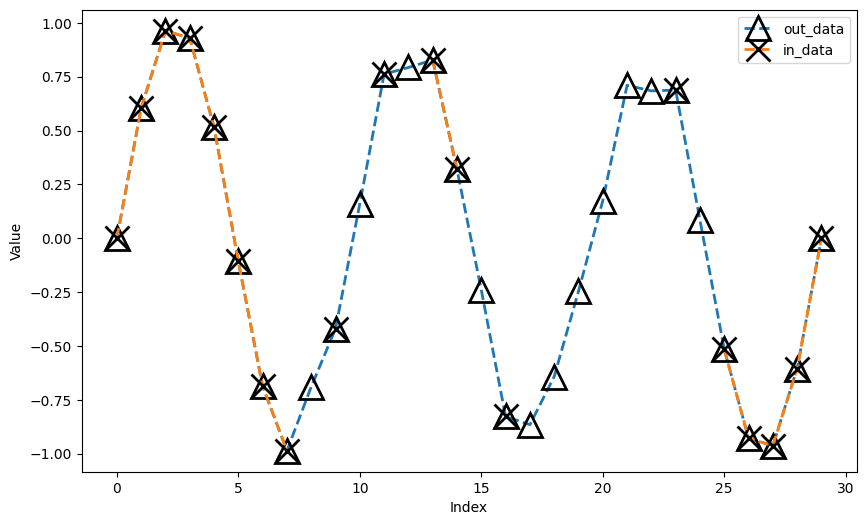

In [ ]:
import numpy as np
from skmap.io import process

n_r = 2
n_s = 30
n_years = 3
# Create a 2D numpy array with sinusoidal waves
in_data = np.empty((n_r, n_s), dtype=np.float32)
for i in range(n_r):
    in_data[i] = np.sin(np.linspace(0, 2*np.pi*n_years, n_s))

# Introduce NaN values randomly for about one-third of the elements
nan_count = int(n_r * n_s / 3)
nan_indices = np.random.choice(n_r * n_s, nan_count, replace=False)
in_data.ravel()[nan_indices] = np.nan


out_data_trans = np.empty(in_data.shape, dtype=np.float32)
out_index_offset = 0
n_threads = 96
keep_original_values = True
version = 'v2'
backend = 'Matrix'
n_seas = int(n_s/n_years)
w_p = (get_SWAG_weights(46, 45, n_seas, n_s)[1:][::-1]).astype(np.float32)
w_f = (get_SWAG_weights(46, 45, n_seas, n_s)[1:]).astype(np.float32)
w_0 = 1.0 

skmap_bindings.applySircle(in_data, n_threads, out_data_trans, out_index_offset, w_0, w_p, w_f, keep_original_values, version, backend)

data = np.zeros((1, n_r, n_s))
data[0,:,:] = in_data.copy()
sircleTransformer = process.SircleTransformer(wv_0=1, wv_f=w_f, wv_p=w_p, backend="dense", use_mask=True)
out_Python = sircleTransformer._run(data)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Get the first row of in_data and out_data
in_data_first_row = in_data[0]
out_data_first_row = out_data_trans[0]
out_python_first_row = out_Python[0,0,:]
ms = 17
lw = 2
mw = 2
# Create the plot
plt.plot(out_data_first_row, '^',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, label='out_data')
# plt.plot(out_python_first_row, '.',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, label='out_Python')
plt.plot(in_data_first_row, 'x',  mfc='none', mec='k', markersize=ms, linestyle='--', linewidth=lw, markeredgewidth=mw, label='in_data')


# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()


In [ ]:
out_python_first_row-out_data_first_row

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.02328945e-09,  0.00000000e+00,  5.22311305e-08,
        0.00000000e+00,  0.00000000e+00,  2.52340950e-09,  0.00000000e+00,
        4.50799912e-08, -4.71414661e-08,  0.00000000e+00, -2.53532356e-09,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.19745547e-08,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -9.49696399e-09,  0.00000000e+00, -9.57519831e-08,
       -7.90286447e-09, -4.24223964e-08])